Домашнее задание:

* К вам приходит руководитель продукта “Интернет-магазин” 
* И спрашивает про удержание клиентов и повторные покупки
* У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи
* Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Данные лежат в папке занятия на сервере:

* есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
* orders.csv, customers.csv

**Ваши задачи:**

1. Проверить гипотезу руководителя продукта 
2. Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

Ответ может быть в любом формате 

**ДЕДЛАЙН: до 23:59 02.02.2022**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from statsmodels.stats.proportion import proportions_ztest

In [2]:
customers = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')

In [3]:
customers['segment'].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

Из данных следует, что сейчас 2017 год. Поэтому удалим историю раньше 2016 года

In [4]:
orders = orders.drop_duplicates()
orders['OrderDate'] = pd.to_datetime(orders['order_date'],infer_datetime_format=True)
orders['OrderMonth'] = orders['OrderDate'].dt.strftime('%Y-%m') 
orders['OrderYear'] = orders['OrderDate'].dt.strftime('%Y') 
# orders = orders[orders['OrderYear'] >= '2016']
orders.head()

,id,order_date,ship_mode,customer_id,sales,OrderDate,OrderMonth,OrderYear
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09-07,2014-09,2014
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07-08,2014-07,2014
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03-14,2014-03,2014
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01-28,2014-01,2014
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04-08,2014-04,2014


Посчитаем кол-во клиентов на начало 2016 и 2017 года

In [5]:
clients_before_2016 = set(orders[orders['OrderYear'] < '2016']['customer_id'])
clients_before_2017 = set(orders[orders['OrderYear'] < '2017']['customer_id'])
len(clients_before_2016), len(clients_before_2017)

(731, 782)

Посчитаем кол-во новых клиентов  2016 и 2017 года

In [6]:
clients_2016 = set(orders[orders['OrderYear'] == '2016']['customer_id'])
clients_2017 = set(orders[orders['OrderYear'] == '2017']['customer_id'])
new_2016 = clients_2016 - clients_before_2016
new_2017 = clients_2017 -  clients_before_2017

len(clients_2016), len(new_2016), len(clients_2017), len(new_2017)

(638, 51, 693, 11)

Посчитаем отток

In [7]:
outflow_2016 = (len(clients_before_2016) + len(new_2016) - len(clients_2016)) / len(clients_before_2016)
outflow_2017 = (len(clients_before_2017) + len(new_2017) - len(clients_2017)) / len(clients_before_2017)
outflow_2016, outflow_2017

(0.19699042407660738, 0.1278772378516624)

In [8]:
_, pval = proportions_ztest(
    [
        len(clients_before_2016) + len(new_2016) - len(clients_2016),
        len(clients_before_2017) + len(new_2017) - len(clients_2017)
    ],
    [
        len(clients_before_2016), len(clients_before_2017)
    ]
)

if pval < 0.05:
    print('Churn Rate изменился')
else:
    print('Churn Rate не изменился')

Churn Rate изменился


Проведем тоже самое для каждого месяца с 2016 года

In [9]:
def get_churn_rate_month(period, period_last, df, period_col='OrderMonth'):
    
    users_before = set(df[df[period_col] == period_last]['customer_id'])
    users_period = set(df[df[period_col] == period]['customer_id'])
    new_users = users_period - users_before    
    return (len(users_before) + len(new_users) - len(users_period)) / len(users_before)


def get_churn_rate_window(period, period_last, df):
    users_before = set(df[df['OrderYear'] == period_last]['customer_id'])
    users_period = set(df[(df['OrderMonth'] <= period) & (df['OrderYear'] > period_last)]['customer_id'])
    new_users = users_period - users_before
    return (len(users_before) + len(new_users) - len(users_period)) / len(users_before)

In [10]:
periods = sorted(orders[orders['OrderYear'] >= '2016']['OrderMonth'].unique())
churn_rate_by_month = []
for i in range(1, len(periods)):
    churn_rate_by_month.append(get_churn_rate_month(periods[i], periods[i-1], orders))


No handles with labels found to put in legend.


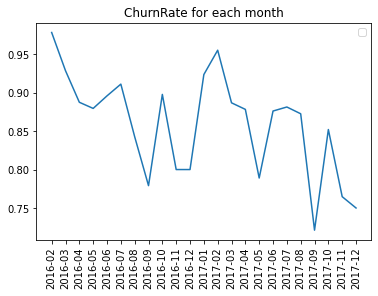

In [11]:
plt.plot(periods[1:], churn_rate_by_month)
plt.title('ChurnRate for each month')
plt.legend()
plt.xticks(rotation=90);

Возможно из-за специфики интернет-магазина покупатели не каждый месяц покупают данные товары. Поэтому помесячный churn rate такой высокий. Но даже отсюда видим убывающую динамику метрики

Поэтому посмотрим на скользящий ChurnRate за год. За базу возьмем всех клиентов в предыдущем году

In [12]:
df_sets = {
    'total': orders,
    'Consumer': orders.merge(customers[customers['segment'] == 'Consumer'], 
                             how='inner', left_on='customer_id', right_on='id'),
    'Corporate': orders.merge(customers[customers['segment'] == 'Corporate'], 
                              how='inner', left_on='customer_id', right_on='id'),
    'Home Office': orders.merge(customers[customers['segment'] == 'Home Office'], 
                                  how='inner', left_on='customer_id', right_on='id')

    
} 

In [13]:
periods_2016 = sorted(orders[orders['OrderYear'] == '2016']['OrderMonth'].unique())
churn_rate_flow_2016 = defaultdict(list)

for i in range(1, len(periods_2016)):
    for set_type in ['total', 'Consumer', 'Corporate', 'Home Office']:
        churn_rate_flow_2016[set_type].append(get_churn_rate_window(periods_2016[i], '2015', df_sets[set_type]))


In [14]:
periods_2017 = sorted(orders[orders['OrderYear'] == '2017']['OrderMonth'].unique())
churn_rate_flow_2017 = defaultdict(list)

for i in range(1, len(periods_2017)):
    for set_type in ['total', 'Consumer', 'Corporate', 'Home Office']:
        churn_rate_flow_2017[set_type].append(get_churn_rate_window(periods_2017[i], '2016', df_sets[set_type]))
        



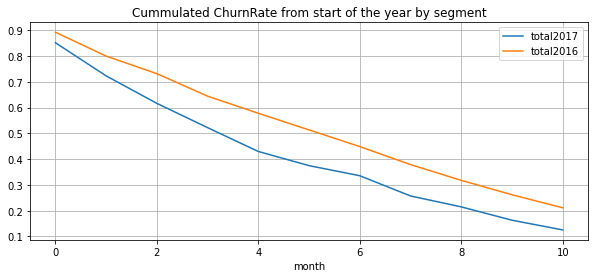

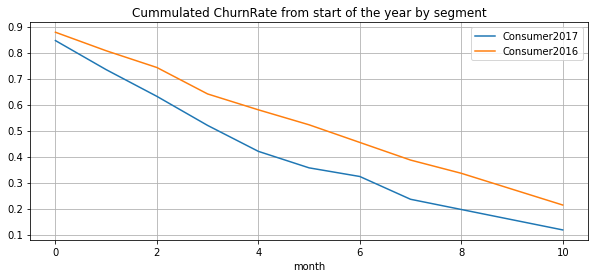

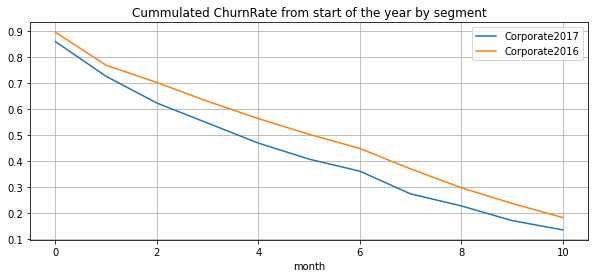

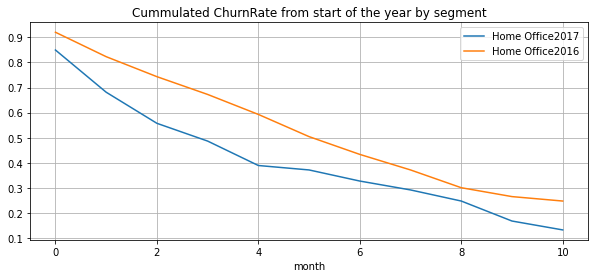

In [15]:

for set_name in churn_rate_flow_2016:
    
    plt.figure(figsize=(10, 4))


    plt.plot(churn_rate_flow_2017[set_name], label=set_name + '2017')
    plt.plot(churn_rate_flow_2016[set_name], label=set_name + '2016')

    plt.title('Cummulated ChurnRate from start of the year by segment')
    plt.legend()
    plt.grid()
    plt.xlabel('month')

Также видим, что за одинаковые промежутки времени в 2017 году ChurnRate был ниже

Проделаем тоже самое в разрезе по типам доставки

In [16]:
df_sets = {
    'total': orders,
    'Standard': orders[orders['ship_mode'] == 'Standard'],
    'Second': orders[orders['ship_mode'] == 'First'],
    'First': orders[orders['ship_mode'] == 'Second'],
    'Same Day': orders[orders['ship_mode'] == 'Same Day'],

    
} 

In [19]:
periods_2016 = sorted(orders[orders['OrderYear'] == '2016']['OrderMonth'].unique())
churn_rate_flow_2016 = defaultdict(list)

for i in range(1, len(periods_2016)):
    for set_type in df_sets:
        churn_rate_flow_2016[set_type].append(get_churn_rate_window(periods_2016[i], '2015', df_sets[set_type]))



In [20]:
periods_2017 = sorted(orders[orders['OrderYear'] == '2017']['OrderMonth'].unique())
churn_rate_flow_2017 = defaultdict(list)

for i in range(1, len(periods_2017)):
    for set_type in df_sets:
        churn_rate_flow_2017[set_type].append(get_churn_rate_window(periods_2017[i], '2016', df_sets[set_type]))
        




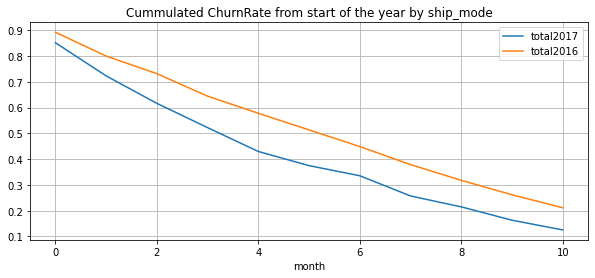

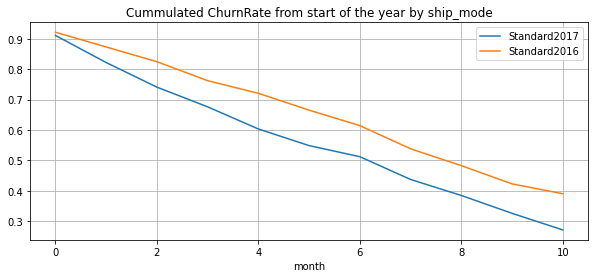

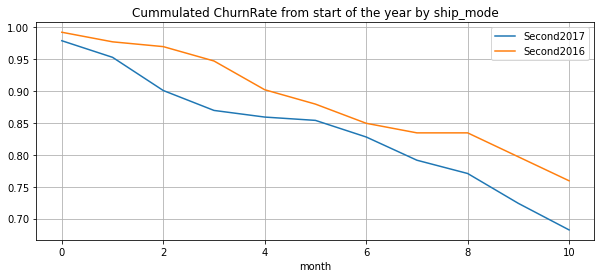

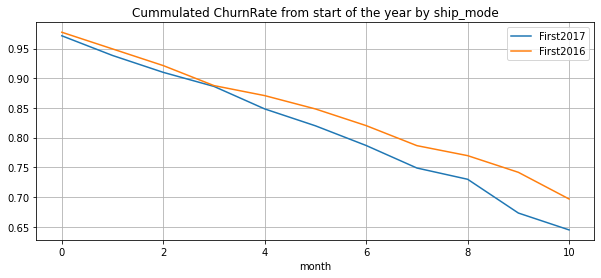

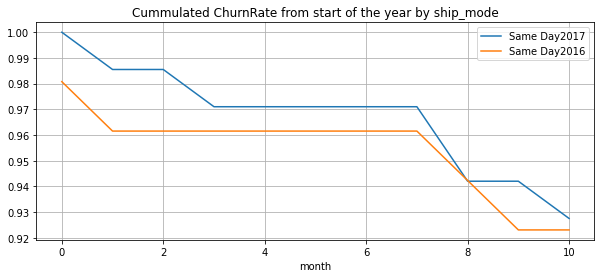

In [21]:

for set_name in churn_rate_flow_2016:
    
    plt.figure(figsize=(10, 4))


    plt.plot(churn_rate_flow_2017[set_name], label=set_name + '2017')
    plt.plot(churn_rate_flow_2016[set_name], label=set_name + '2016')

    plt.title('Cummulated ChurnRate from start of the year by ship_mode')
    plt.legend()
    plt.grid()
    plt.xlabel('month')

Для всех типов доставки кроме 'Same day' churn rate в 2017 году ниже. Что-то произошло в начале 2017 года, что клиенты переставали заказывать доставку 'Same day'. Но к концу года резко вернулись